In [35]:
# Importing the PIL library
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
# other things
import pandas as pd
import os
import os.path as op
import json
import numpy as np

In [36]:
# set path
sdir = '/Users/gf57/Dropbox/General/Projects/NaturalReading/Experiment/scripts/MethodsMeeting/'

In [74]:
### Primary function to make a single stimulus
def make_stim_image(stim, row, col, sdir):
    '''Takes text in a string, a row of a stimulus pd data frame, 
    and a column name, and saves three things as outputs:
    1. The image of the text, to be used in the experiment.
    2. The same image, but with bounding boxes displayed around each word.
    3. A .json file containing a dictionary with the x and y coordinates that
    define each word and its bounding box.
    
    Arguments:
    stim: a string specifying the text to be put on this image
    row: a row of pandas dataframe containing the string in stim
    col: the name of the column in which the stimuli are found
    sdir: the directory for the project
    '''
    
    # make some directories if they don't exist
    if not op.exists(sdir + 'STIMULI/images'):
        os.makedirs(sdir + 'STIMULI/images')
    if not op.exists(sdir + 'STIMULI/w_boxes'):
        os.makedirs(sdir + 'STIMULI/w_boxes')
    if not op.exists(sdir + 'STIMULI/coords'):
        os.makedirs(sdir + 'STIMULI/coords')
    
    # get rid of extra spaces:
    clear = 0
    while clear == 0:
        if stim[-1] == ' ':
            stim = stim[:-1]
        else:
            clear = 1
    # load in background
    img = Image.open(sdir + 'Background.png')
    # draw it
    I1 = ImageDraw.Draw(img)
    # set font size and width and height
    myfont = ImageFont.truetype('Courier New', 20)
    size = myfont.getsize(stim)
    # Get width and height of background image: THESE MATCH THE PROJECTOR DISPLAY RESOLUTION
    width, height = img.size

    # get letter size in pixels: width of each letter
    Lsize = size[0]/len(stim)

    # find the middle
    center = width/2
    # find vertical center
    v_center = height/2 - size[1]
    # get width of whole item
    item_length = size[0]
    # figure out left position
    offset_from_center = item_length/2
    # set horizontal offset
    horiz_start = center - offset_from_center
    # insert stimulus into the image and save
    I1.text((horiz_start, v_center), stim, font=myfont, fill = (255,255,255))
    # save it
    code = str(row['set_id']) + row['cond_id']
    # use this to draw photodiode patch
    I1.rectangle([(0,50),(50,0)],fill='white',outline='white')
    img.save(sdir + 'STIMULI/images/%s' %(code), format='bmp')
    ### NOW GET THE WORD POSITIONS AND SAVE THE BOUNDING BOXES ###
    # split the stimulus into words
    words = str.split(stim, ' ')
    # get the positions of each word
    sentence_dict = {}
    for w in words:
        if w != words[-1]:
            w = w + ' '
        # calculate word ssize
        wsize = Lsize * len(w)

        # define the starting x: left
        if w == words[0]+ ' ':
            word_x_start = horiz_start # if first word, it's the offset
            word_x_start = word_x_start - Lsize*0.5
            word_x_end = horiz_start + Lsize*len(w) - Lsize*0.5
            next_word_x_start = word_x_end # + Lsize

        elif w == words[-1]:
            word_x_start = next_word_x_start
            word_x_end = word_x_start + Lsize*len(w) + Lsize
            #next_word_x_start = word_x_end #+ Lsize*0.5
        else:
            word_x_start = next_word_x_start
            word_x_end = word_x_start + Lsize*len(w) #- Lsize #*Lsize*0.5
            next_word_x_start = word_x_end #+ Lsize*0.5

        # define the y bounds: line number
        word_y_start = v_center #+ size[1] #* ll
        word_y_end = v_center + size[1] #* (ll+1)

        # FOR NOW: add some padding to the y range to capture vertical inaccuracy
        word_y_start = word_y_start - 25
        word_y_end = word_y_end + 25

        # add to sentence dictionary
        sentence_dict[w] = [word_x_start,word_x_end,word_y_start,word_y_end]
        I1.rectangle([(word_x_start,word_y_start),(word_x_end,word_y_end)],fill=None,outline='white')
    # save the iamge with bounding box
    img.save(sdir + 'STIMULI/w_boxes/%s' %(code), format='bmp')
    # save the dictionary as a json file
    json.dump(sentence_dict, open(sdir+ 'STIMULI/coords/%s.json' %(code), "w"))


# Run the Function to Generate Images

In [52]:
# load stimuli
stimuli = pd.read_csv(sdir + 'stim.csv')

In [53]:
# take a look
stimuli.head()

,set_id,cond_id,stim,cond,match,word1_mis,word2_mis,word3_mis,structure,meaning,n_word,n_char_stim,stim_word1,stim_word2,stim_word3
0,1,a,students read books,svo,students read books,rodents read books,students rate books,students read beets,SVO,canonical,3.0,19,students,read,books
1,1,b,books read students,reversed,books read students,beets read students,books rate students,books read rodents,SVO,reversed,3.0,19,books,read,students
2,1,c,students reads books,agr_fw,students reads books,rodents reads books,students rates books,students reads beets,AgrErr,canonical,NaN,20,students,reads,books
3,1,d,books reads students,agr_rv,books reads students,beets reads students,books rates students,books reads rodents,AgrErr,reversed,NaN,20,books,reads,students
4,1,e,students books,list_fw,students books,rodents books,students beets,students books,NoVerbList,canonical,2.0,14,students,books,NaN


# Loop over the rows of the dataframe to make each image

In [54]:
for idx, row in stimuli.iterrows():
    
    col = 'stim' # the name of the column in teh dataframe that contains the stim

    stim = row[col] # the actual stimulus in this row
    
    # comment this out if desired:
    print('Making images for stimulus: %s' %stim)
    
    # run the function
    make_stim_image(stim, row, col, sdir)

Making images for stimulus: students read books
Making images for stimulus: books read students
Making images for stimulus: students reads books
Making images for stimulus: books reads students
Making images for stimulus: students books
Making images for stimulus: books students
Making images for stimulus: students read
Making images for stimulus: books read
Making images for stimulus: books students read
Making images for stimulus: students books read


# Load in images and a dictionary to see what it looks like

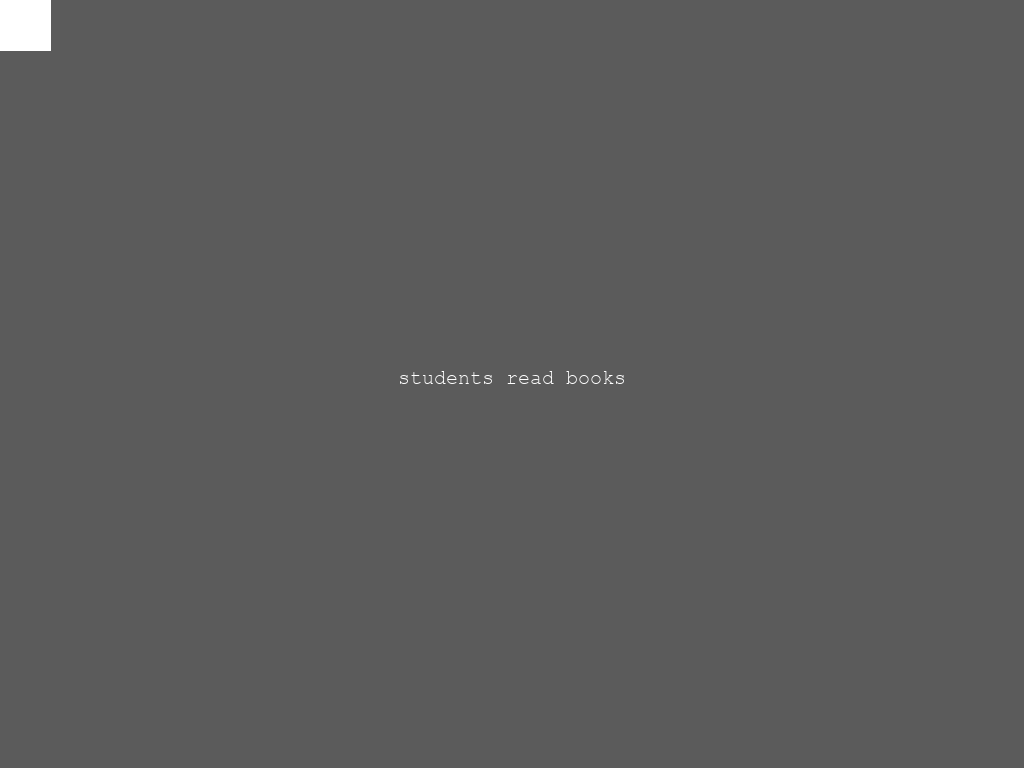

In [55]:
img = Image.open(sdir + 'STIMULI/images/1a')
I1 = ImageDraw.Draw(img)
display(img)

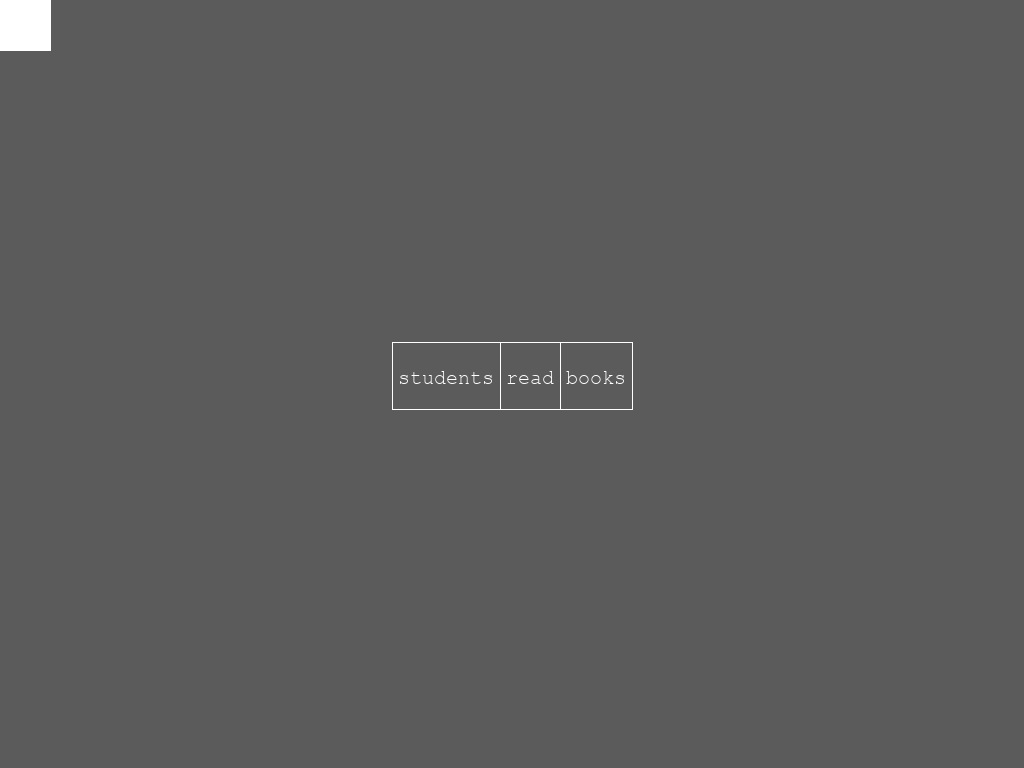

In [56]:
img = Image.open(sdir + 'STIMULI/w_boxes/1a')
I1 = ImageDraw.Draw(img)
display(img)

In [59]:
# print out the dictionary
coords = json.load(open(sdir + 'STIMULI/coords/1a.json'))
# x0, x1, y0, y1
print(coords)

{'students ': [392.0, 500.0, 342.0, 409.0], 'read ': [500.0, 560.0, 342.0, 409.0], 'books': [560.0, 632.0, 342.0, 409.0]}


In [70]:
print('Bounding box for the first word:')
coords[list(coords.keys())[0]]

Bounding box for the first word:


[392.0, 500.0, 342.0, 409.0]